In [1]:
!pip install transformers
!pip install torch
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
    # Print the bounding box coordinates explicitly
    print(f"Bounding box coordinates: {box}")


Detected remote with confidence 0.998 at location [40.16, 70.81, 175.55, 117.98]
Bounding box coordinates: [40.16, 70.81, 175.55, 117.98]
Detected remote with confidence 0.996 at location [333.24, 72.55, 368.33, 187.66]
Bounding box coordinates: [333.24, 72.55, 368.33, 187.66]
Detected couch with confidence 0.995 at location [-0.02, 1.15, 639.73, 473.76]
Bounding box coordinates: [-0.02, 1.15, 639.73, 473.76]
Detected cat with confidence 0.999 at location [13.24, 52.05, 314.02, 470.93]
Bounding box coordinates: [13.24, 52.05, 314.02, 470.93]
Detected cat with confidence 0.999 at location [345.4, 23.85, 640.37, 368.72]
Bounding box coordinates: [345.4, 23.85, 640.37, 368.72]


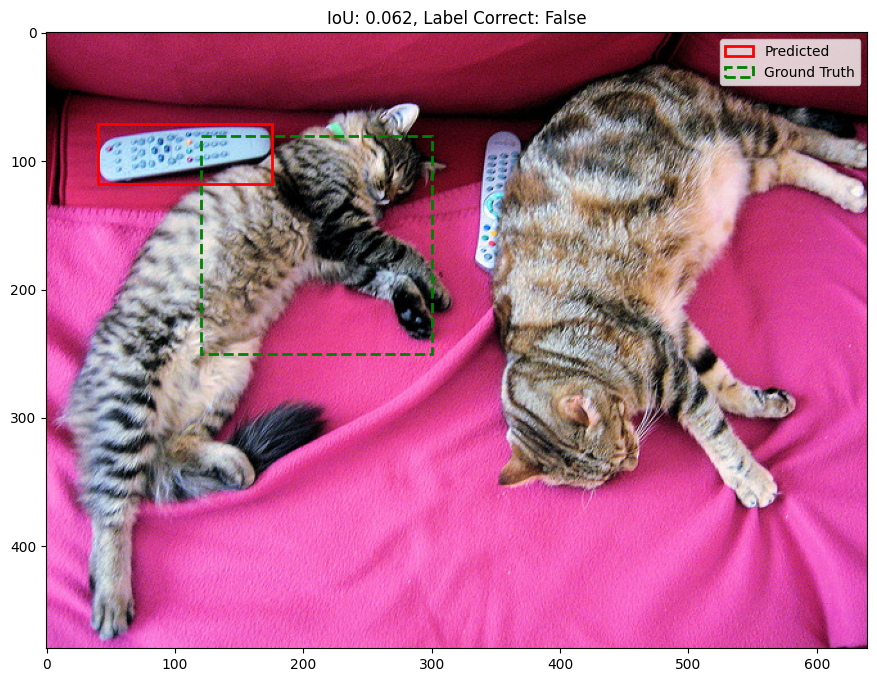

IndexError: list index out of range

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# To calculate IoU (intersection over union, given two bounding boxes)
def bounding_box_intersection_over_union(box_predicted, box_truth):
    # get (x, y) coordinates of intersection of bounding boxes
    top_x_intersect = max(box_predicted[0], box_truth[0])
    top_y_intersect = max(box_predicted[1], box_truth[1])
    bottom_x_intersect = min(box_predicted[2], box_truth[2])
    bottom_y_intersect = min(box_predicted[3], box_truth[3])

    # calculate area of the intersection bb (bounding box)
    intersection_area = max(0, bottom_x_intersect - top_x_intersect + 1) * max(
        0, bottom_y_intersect - top_y_intersect + 1
    )

    # calculate area of the prediction bb and ground-truth bb
    box_predicted_area = (box_predicted[2] - box_predicted[0] + 1) * (
        box_predicted[3] - box_predicted[1] + 1
    )
    box_truth_area = (box_truth[2] - box_truth[0] + 1) * (
        box_truth[3] - box_truth[1] + 1
    )

    # calculate intersection over union by taking intersection
    # area and dividing it by the sum of predicted bb and ground truth
    # bb areas subtracted by the intersection area
    return intersection_area / float(
        box_predicted_area + box_truth_area - intersection_area
    )


# Ground truth data for comparison (dummy values for demonstration)
ground_truth_boxes = [
    [120, 80, 300, 250],  # Example ground truth bounding boxes
]
ground_truth_labels = [1]  # Example ground truth labels (change as per your dataset)

mean_iou = 0
correct_label_count = 0
total_predictions = 0

# Process and compare the results
for i, (score, label, box) in enumerate(zip(results["scores"], results["labels"], results["boxes"])):
    total_predictions += 1

    # Predicted bounding box and label
    box_predicted = [round(i, 2) for i in box.tolist()]
    label_predicted = label.item()

    # Ground truth bounding box and label for comparison
    box_truth = ground_truth_boxes[i]
    label_truth = ground_truth_labels[i]

    # Calculate IoU
    iou = bounding_box_intersection_over_union(box_predicted, box_truth)
    mean_iou += iou

    # Check label correctness
    if label_predicted == label_truth:
        correct_label_count += 1

    # Plot the results
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(image)
    rect_pred = patches.Rectangle(
        (box_predicted[0], box_predicted[1]),
        box_predicted[2] - box_predicted[0],
        box_predicted[3] - box_predicted[1],
        linewidth=2, edgecolor='red', facecolor='none', label="Predicted"
    )
    rect_truth = patches.Rectangle(
        (box_truth[0], box_truth[1]),
        box_truth[2] - box_truth[0],
        box_truth[3] - box_truth[1],
        linewidth=2, edgecolor='green', facecolor='none', linestyle='dashed', label="Ground Truth"
    )
    ax.add_patch(rect_pred)
    ax.add_patch(rect_truth)
    plt.legend()
    plt.title(f"IoU: {iou:.3f}, Label Correct: {label_predicted == label_truth}")
    plt.show()

# Final statistics
print(f"Mean IoU: {mean_iou / total_predictions:.3f}")
print(f"Correct Labels: {correct_label_count}/{total_predictions}")
